<a href="https://colab.research.google.com/github/IANovoselov/well/blob/main/well.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd

In [2]:
 # Исходные данные для моделировния

# Фонтанирующая скважина
# p_R = 28  # Среднепластовое давление
# p_G0 = 25  # Давление насыщенного газа

# Нефонтанирующая скважина
p_R = 21.65  # Среднепластовое давление
p_G0 = 17.32  # Давление насыщенного газа

H_R = 3000  # Глубина забоя по вертикали
w_1 = 12  # Гидропроводность из пласта в ПЗ скважины
w_2 = 60  # Гидропроводность из ПЗ в забой
betta = 0.3  # Объёмная доля воды
p_0 = 0.1  # Атмосферное давление

# Удельный вес
gamma_oil = 0.0068  # нефти
gamma_water = 0.011  # воды
gamma_gas = 0.000008  # газа
G = 100  # Газовый фактор
p_L = 1.5  # Давление в линии нефтесбора

# Гидросопротивление
r_K = 0.5  # обсадной колонный
r_N = 4  # НКТ
r_T = 0.8  # затрубного пространства
r_U = 2  # устьевого штуцера
r_GU = 2  # перепускного клапана

# Параметры насоса
H_N = 2000  # уровень подвеса
q_0 = 60  # номинальный дебит

# Напорная характеристика
q_Pump = [5/3, 4/3, 2/3]
lambda_0 = [10/3, 2, 3/2]
lambda_1 = [2, 1, 1/4]

In [3]:
# Моделируемые данные, начальные условия
_q_N = []
_q_T = []
__q = []
_p_1 = []
_p_2 = []
_p_3 = []
_p_5 = []
_p_4 = []
_p_8 = []
_u = []
_h_4 = []

In [4]:
# Статический расчёт скважины

# Гидросопротивления
r_1 = 1/w_1  # Пласт - ПЗ
r_2 = 1/w_2  # ПЗ - забой
r_R = r_1 + r_2
r_R

0.09999999999999999

In [5]:
# Ограничения
h_lim = 100  # По уровню над приёмом насос
betta_G_lim = 0.25  # По газу у первой ступени

In [6]:
# Высота столба жидкости
gamma = (1-betta)*gamma_oil+betta*gamma_water
dH_R =  (p_R-p_L)/gamma - H_R
dH_R

-500.0

In [7]:
h_0 = q_0*(r_U + r_N + r_K + r_R/gamma) - dH_R

In [8]:
alpha_G_3 = 0.4
alpha_betta = 0.333
k_S = 0.7
X_G = 0.00008

M_R3 = (1-betta)*G*((alpha_G_3*p_0) / (p_G0 - p_0))
p_G3 = p_G0 * (((1-k_S)*M_R3)/(((1-k_S)*M_R3)+alpha_betta))

a_GU = k_S*X_G*M_R3

In [9]:
# Расчёт динамики

# Начальные условия

M_q = 0.5

h_4 = H_N + dH_R
p_2 = p_R
t = 0
w = 1
q = 0
p_3 = p_L + gamma * h_4
epsilon = 0.01 * p_3

# Сегмент напорной характеристики
i = 1

q = (p_2 - p_3 - gamma*(H_R-H_N)) / (r_1 + gamma * r_K)
__p_3 = (p_L + p_G0 * r_GU * np.sqrt(w) * a_GU * q + gamma * h_4) / (1 + r_GU * np.sqrt(w) * a_GU * q)
# Балансировка притока по начальным условиям
while abs(p_3 - __p_3) > epsilon:
    p_3 = (1 - M_q)*p_3 + M_q *__p_3
    q = (p_2 - p_3 - gamma*(H_R-H_N)) / (r_1 + gamma * r_K)
    __p_3 = (p_L + p_G0 * r_GU * np.sqrt(w) * a_GU * q_0 + gamma * h_4) / (1 + r_GU * np.sqrt(w) * a_GU * q_0)

In [10]:
# Начало расчёта
for k in range(15000):

    p_3 = (p_L + p_G0 * r_GU * np.sqrt(w) * a_GU * q + gamma * h_4) / (1 + r_GU * np.sqrt(w) * a_GU * q)
    q = (p_2 - p_3 - gamma*(H_R-H_N)) / (r_1 + gamma * r_K)


    # Расчёт подачи

    q_N = (w*w*h_0*lambda_0[i] - H_N + (1/gamma)*(p_3 - p_L)) / (w*(h_0/q_0)*lambda_1[i]+r_U+r_N)
    q_N = max(q_N, 0)

    if w*q_0*q_Pump[0] <= q_N <= w*q_0*q_Pump[1]:
        i = 0
        q_N = (w*w*h_0*lambda_0[i] - H_N + (1/gamma)*(p_3 - p_L)) / (w*(h_0/q_0)*lambda_1[i]+r_U+r_N)
        q_N = max(q_N, 0)

    if w*q_0*q_Pump[1] < q_N < w*q_0*q_Pump[2]:
        i = 1
        q_N = (w*w*h_0*lambda_0[i] - H_N + (1/gamma)*(p_3 - p_L)) / (w*(h_0/q_0)*lambda_1[i]+r_U+r_N)
        q_N = max(q_N, 0)

    if w*q_0*q_Pump[1] <= q_N <= w*q_0*q_Pump[2]:
        i = 2
        q_N = (w*w*h_0*lambda_0[i] - H_N + (1/gamma)*(p_3 - p_L)) / (w*(h_0/q_0)*lambda_1[i]+r_U+r_N)
        q_N = max(q_N, 0)



    betta_G3 = (M_R3*(p_G0 - p_3)) / (p_3 + M_R3*(p_G0 - p_3))
    M_RS = (1 - k_S*np.sqrt(w))* M_R3
    betta_GN = (M_RS*(p_G0 - p_3)) / (p_3 + M_RS*(p_G0 - p_3))

    h_4 = (1/gamma)*(p_3 - p_L - r_GU*np.sqrt(w)*a_GU*(p_G0-p_3)*q)

    p_1 = p_R - r_R*q

    _p_1.append(p_1)
    _p_3.append(p_3)
    _q_N.append(q_N)
    __q.append(q)
    _h_4.append(h_4)
    _u.append(w)

    # Шаг по Эйлеру

    p_2 = p_2 + (0.0001/0.4)*(p_R - p_2 - r_2*q)
    h_4 = h_4 + (0.0001/0.01)*(q-q_N)


In [11]:
x = np.linspace(0, 1.5, 15000)
x

array([0.00000000e+00, 1.00006667e-04, 2.00013334e-04, ...,
       1.49979999e+00, 1.49989999e+00, 1.50000000e+00])

In [12]:
df = pd.DataFrame({'q_N': _q_N, 'p_3': _p_3, 'p_1': _p_1, 'q': __q, 'h_4': _h_4, 'u': _u, 'x': x})

In [13]:
df

,q_N,p_3,p_1,q,h_4,u,x
0,83.297543,13.590000,21.650000,0.000000,1500.000000,1,0.0000
1,83.272484,13.583286,21.642315,0.076849,1499.166376,1,0.0001
2,83.247455,13.576581,21.634640,0.153600,1498.333770,1,0.0002
3,83.222457,13.569883,21.626975,0.230254,1497.502182,1,0.0003
4,83.197490,13.563194,21.619319,0.306810,1496.671610,1,0.0004
...,...,...,...,...,...,...,...
14995,60.100595,7.375151,15.648388,60.016115,727.578358,1,1.4996
14996,60.100570,7.375144,15.648389,60.016111,727.577514,1,1.4997
14997,60.100544,7.375137,15.648389,60.016107,727.576669,1,1.4998
14998,60.100519,7.375131,15.648390,60.016103,727.575825,1,1.4999


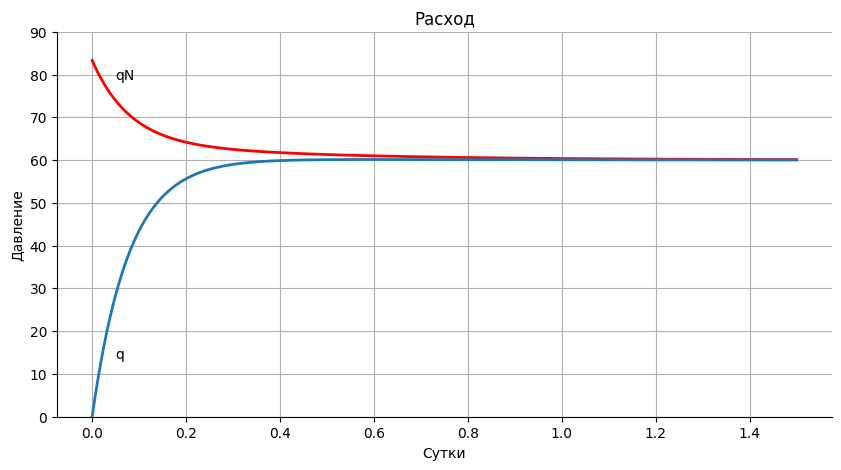

In [55]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.gca().spines[['top', 'right']].set_visible(False)
# plot one by one

plt.plot(df['x'], df['q_N'], 'r', lw=2)
plt.plot(df['x'], df['q'], lw=2)


# set x label
plt.xlabel('Сутки')
plt.ylabel('Давление')

# set title
plt.title('Расход')


plt.ylim(0, 90)
plt.grid(True)

plt.annotate('q', xy = (df['x'][500],df['q'][200] ))
plt.annotate('qN', xy = (df['x'][500],df['q_N'][200] ))
# display plot
plt.show()


In [15]:
df['q_N']

,q_N
0,83.297543
1,83.272484
2,83.247455
3,83.222457
4,83.197490
...,...
14995,60.100595
14996,60.100570
14997,60.100544
14998,60.100519


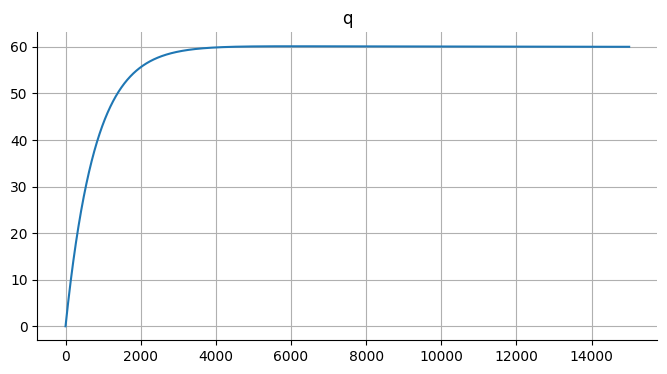

In [16]:
from matplotlib import pyplot as plt
df['q'].plot(kind='line', figsize=(8, 4), title='q', grid=True)
plt.gca().spines[['top', 'right']].set_visible(False)

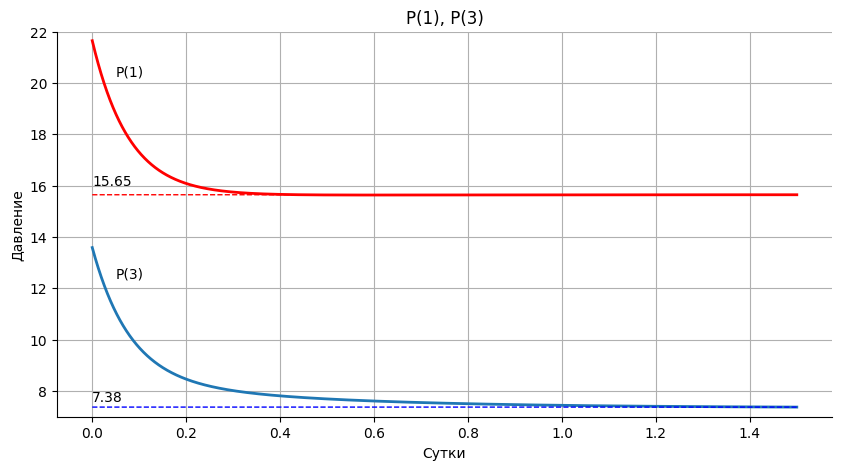

In [53]:
from matplotlib import pyplot as plt
plt.figure(figsize=(10, 5))
plt.gca().spines[['top', 'right']].set_visible(False)
# plot one by one


plt.plot(df['x'], df['p_1'],'r', lw=2)
plt.plot(df['x'], [df['p_1'][14999]]*15000,'r--', lw=1)

plt.plot(df['x'], df['p_3'], lw=2)
plt.plot(df['x'], [df['p_3'][14999]]*15000,'b--', lw=1)

# set x label
plt.xlabel('Сутки')
plt.ylabel('Давление')

# set title
plt.title('P(1), P(3)')


plt.ylim(7, 22)
plt.grid(True)
plt.annotate('P(1)', xy = (df['x'][500],df['p_1'][200] ))
plt.annotate(str(df['p_1'][14999].round(2)), xy = (0,16))

plt.annotate('P(3)', xy = (df['x'][500],df['p_3'][200] ))
plt.annotate(str(df['p_3'][14999].round(2)), xy = (0,7.6))

# display plot
plt.show()

In [44]:
str(df['p_1'][14999].round(2))

'15.65'

In [18]:
df.iloc[10200]

,10200
q_N,60.337475
p_3,7.438615
p_1,15.644609
q,60.053912
h_4,735.460087
u,1.000000
x,1.020068


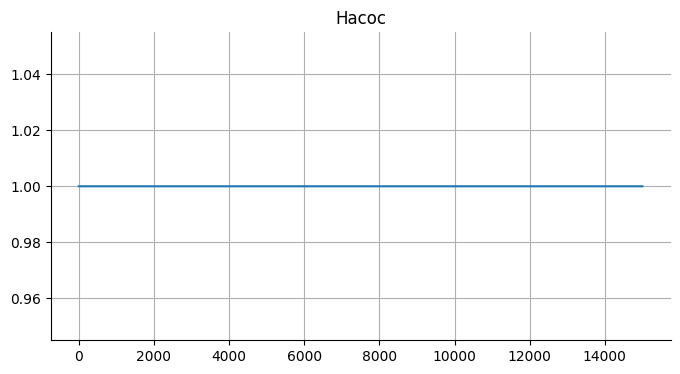

In [19]:
from matplotlib import pyplot as plt
df['u'].plot(kind='line', figsize=(8, 4), title='Насос', grid=True)
plt.gca().spines[['top', 'right']].set_visible(False)